## Отчет по лабораторной работе по курсу "Искусственый интеллект"
## Студент: Аллахвердян Герасим 8о-308б
## Задание: 
Реализовать алгоритм выявляющий взаимосвязанные сообщения на языке Python.
Подобрать или создать датасет и обучить модель.
Продемонстрировать зависимость качества кластеризации от объема, качества выборки и числа кластеров. 
Продемонстрировать работу вашего алгоритма. 
Обосновать выбор данного алгоритма машинного обучения. 
Построить облако слов для центров кластеров.

В качестве источника данных возьмем несколько интернет-форумов разной направленности (молодежной, технической, политической), сведя задачу к определению источника текста. Реализуем собственные грабберы, вытаскивающие достаточное количество текствой информации. В связи с сложностью и многогранностью русского языка, обработаем полученные данные стеммером. В качестве последнего будем использовать MyStem от компании Яндекс. Далее реализуем мешки слов, поверх которых применим алгоритм кластеризации. В данном случае подходит алгоритм K средних, поскольку нам известно количество кластеров, и между мешками слов определяема вещественная обьективная метрика.

In [1]:
import urllib.request
from pymystem3 import Mystem
from scrapy.selector import Selector
from wordcloud import WordCloud
import re
ds_2ch = []
stemmer = Mystem()

def clean_html_post(post):
    post = post.replace('\n', ' ')
    for r in ['&gt;','&lt;','<.*?>', 'https?[^ ]*', '[^ a-zA-Zа-яА-Я]']:
        post = re.sub(re.compile(r), ' ', post)
    return ' '.join(post.split())

def fetch_2ch():
    global ds_2ch
    ds_2ch = []
    for b in ['b','vg','soc','media','r','abu','rf','po','news','au','bi','biz','bo','c','cc','em','fa','fiz','fl','ftb','hh','hi','me','mg','mlp','mo','mov','mu','ne','psy','re','sci','sf','sn','sp','spc','tv','un','w','wh','wm','wp','zog','de','di','diy','mus','pa','p','wrk','trv','gd','hw','mobi','pr','ra','s','t','web','bg','cg','ruvn','tes','v','wr','a','fd','ja','ma','vn']:
        with urllib.request.urlopen('https://2ch.hk/' + b +'/') as response:
            html = response.read().decode()
        dds = Selector(text=html).xpath("//*[contains(@class, 'oppost')]/*[contains(@class, 'post-message')]").extract()
        for s in dds:
            cs = clean_html_post(s)
            if len(cs) > 200:
                ds_2ch.append(cs)
    ds_2ch = list(set(ds_2ch))

%time fetch_2ch()

CPU times: user 3.71 s, sys: 257 ms, total: 3.97 s
Wall time: 18.9 s


In [2]:
ds_lor = []
def fetch_lor():
    global ds_lor
    for b in range(50):
        with urllib.request.urlopen('https://www.linux.org.ru/news/?offset={0}'.format(b*20)) as response:
            html = response.read().decode()
            dds = Selector(text=html).xpath("//div[contains(@class, 'entry-body')]/div[contains(@class, 'msg')]").extract()
            for s in dds:
                cs = clean_html_post(s)
                if cs.endswith('Подробности'):
                    cs = cs[:-11]
                if len(cs) > 100:
                    ds_lor.append(cs)
    ds_lor = list(set(ds_lor))
%time fetch_lor()

CPU times: user 1.36 s, sys: 39 ms, total: 1.4 s
Wall time: 7.61 s


In [3]:
def fetch_war():
    global ds_war
    war_main = urllib.request.urlopen(urllib.request.Request('https://topwar.ru/armament/', headers={'User-Agent': 'Fairfoks'}))
    war_links = set()
    for x in war_main.readlines():
        try:
            s = x.decode()
            for y in  re.findall("https://topwar.ru/[0-9]*-[0-9a-z-]*.html", s):
                war_links.add(y)
        except:
            pass
    ds_war = []
    for article in list(war_links): # oche medleno
        html = urllib.request.urlopen(urllib.request.Request(article, headers={'User-Agent': 'Fairfoks'+str(article[8:12])}))
        content = ''
        for ln in html.readlines():
            try:
                content += ln.decode()
            except:
                pass
        x=Selector(text=content).xpath("//article[contains(@class, 'fullstory')]/div[contains(@class, 'text')]/text()").extract()
        x = clean_html_post(' '.join(i for i in x if not i.isspace()))
        ds_war.append(x)
%time fetch_war()

CPU times: user 4.25 s, sys: 81.4 ms, total: 4.33 s
Wall time: 21.4 s


In [4]:
for x in [ds_2ch, ds_lor, ds_war]:
    print(len(x))

917
129
51


In [5]:
edu_select = ds_2ch[0:10] + ds_war[0:10] + ds_lor[0:10]
print (len(edu_select))

30


In [28]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import collections

def process_text(text, stem=True):
    if stem:
        return [x for x in stemmer.lemmatize(text) if not x.isspace()]
    else:
        return text.split()


""" Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('russian'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
tfidf_model = vectorizer.fit_transform(edu_select)
km_model = KMeans(n_clusters=3,max_iter=1000, n_init=50)
km_model.fit(tfidf_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
km_model.predict(vectorizer.transform(edu_select))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2], dtype=int32)

In [20]:
import tabletext

def print_vectors(v):
    print (tabletext.to_text([[round(i[j], 4) for i in v] for j in range(4)]))

def test_predictor(testdata):
    dc = dict()
    for x in km_model.predict(vectorizer.transform(testdata)):
        if x not in dc:
            dc[x] = 1
        else:
            dc[x] += 1
    return max(dc.values())/len(testdata)
acc = []
for cnt in [1, 2, 5, 10, 20, 40]:
    edu_select = ds_war[0:cnt] + ds_lor[0:cnt] + ds_2ch[0:cnt]
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('russian'),
                                 max_df=0.9,
                                 min_df=0.1,
                                 lowercase=True)
    tfidf_model = vectorizer.fit_transform(edu_select)
    km_model = KMeans(n_clusters=3,max_iter=1000, n_init=50)
    km_model.fit(tfidf_model)
    pv = (test_predictor(ds_war), test_predictor(ds_lor), test_predictor(ds_2ch))
    acc += [(cnt, pv[0], pv[1], pv[2])]
print_vectors(acc)

┌────────┬────────┬────────┬────────┬────────┬────────┐
│      1 │      2 │      5 │     10 │     20 │     40 │
├────────┼────────┼────────┼────────┼────────┼────────┤
│    1.0 │    1.0 │    1.0 │    1.0 │    1.0 │    1.0 │
├────────┼────────┼────────┼────────┼────────┼────────┤
│ 0.6434 │ 0.5581 │ 0.7442 │ 0.9767 │ 0.9767 │  0.969 │
├────────┼────────┼────────┼────────┼────────┼────────┤
│  0.494 │ 0.6707 │ 0.5812 │ 0.9128 │ 0.8059 │ 0.9291 │
└────────┴────────┴────────┴────────┴────────┴────────┘


In [21]:
vectorizer.get_feature_names()

['a',
 'c',
 's',
 'авиационный',
 'авиация',
 'автоматический',
 'автор',
 'активный',
 'американский',
 'аналогичный',
 'апрель',
 'армия',
 'атака',
 'атаковать',
 'база',
 'базовый',
 'благодаря',
 'близкий',
 'боевой',
 'боеприпасы',
 'бой',
 'больший',
 'большой',
 'борт',
 'бортовой',
 'борьба',
 'броня',
 'будущее',
 'быстро',
 'важный',
 'вариант',
 'ведущий',
 'вернуться',
 'вероятность',
 'версия',
 'вертикальный',
 'верхний',
 'вес',
 'вести',
 'весь',
 'весьма',
 'взять',
 'вид',
 'видеть',
 'включать',
 'вместе',
 'вместо',
 'внешний',
 'внимание',
 'внутренний',
 'военный',
 'воздух',
 'воздушный',
 'возможно',
 'возможность',
 'возможный',
 'возникать',
 'война',
 'войско',
 'вооружение',
 'вооруженный',
 'вопрос',
 'вполне',
 'время',
 'вс',
 'вскоре',
 'второй',
 'входить',
 'выбирать',
 'выбор',
 'вывод',
 'выглядеть',
 'вызывать',
 'выполнять',
 'выпуск',
 'выпускать',
 'высокий',
 'высота',
 'выстрел',
 'выход',
 'выходить',
 'г',
 'габарит',
 'главный',
 'говорить

In [10]:
def tf_diff(i, j):
    return sum(tfidf_model[i, x] - tfidf_model[j, x] for x in range(tfidf_model.get_shape()[1]))

In [22]:
def center_words(filt=0.05):
    fs = vectorizer.get_feature_names()
    ans = []
    for i in km_model.cluster_centers_:
        ws = []
        for j in range(0, len(i)):
            if i[j] > filt:
                ws += [(-i[j], fs[j])]
        ws.sort()
        ans += [list(x[1] for x in ws)]
    print (ans)
    return ans
wcs = []
for c in center_words():
    cwc = WordCloud(width=1280, height=720).generate(' '.join(c))
    wcs.append(cwc)

[['версия', 'новый', 'читать', 'поддержка', 'далеко', 'приложение', 'сайт', 'год', 'программа', 'свободный', 'разработчик', 'выпуск', 'проект', 'позволять', 'который'], ['оружие', 'ракета', 'год', 'боевой', 'это', 'новый', 'который', 'мочь', 'самолет', 'патрон', 'машина', 'танк', 'система', 'корабль', 'мм', 'проект', 'часть', 'вооружение', 'время', 'иметь', 'комплекс', 'м', 'корпус', 'цель'], ['тред', 'весь', 'это', 'вопрос', 'a', 'мочь']]


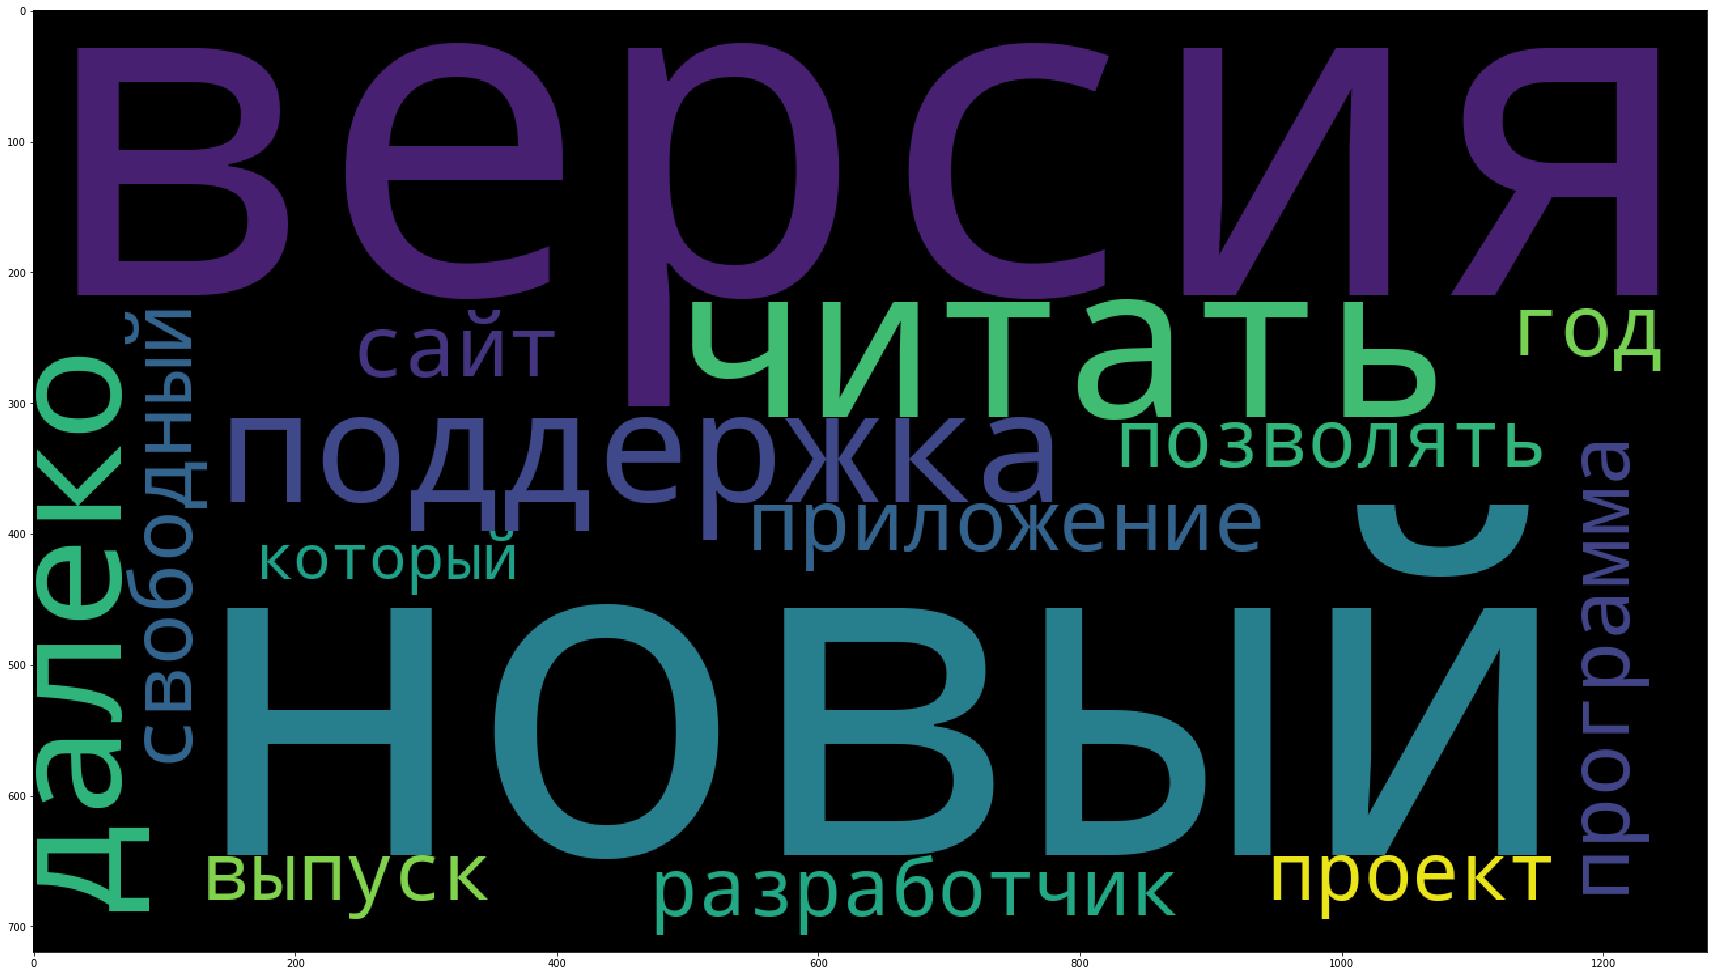

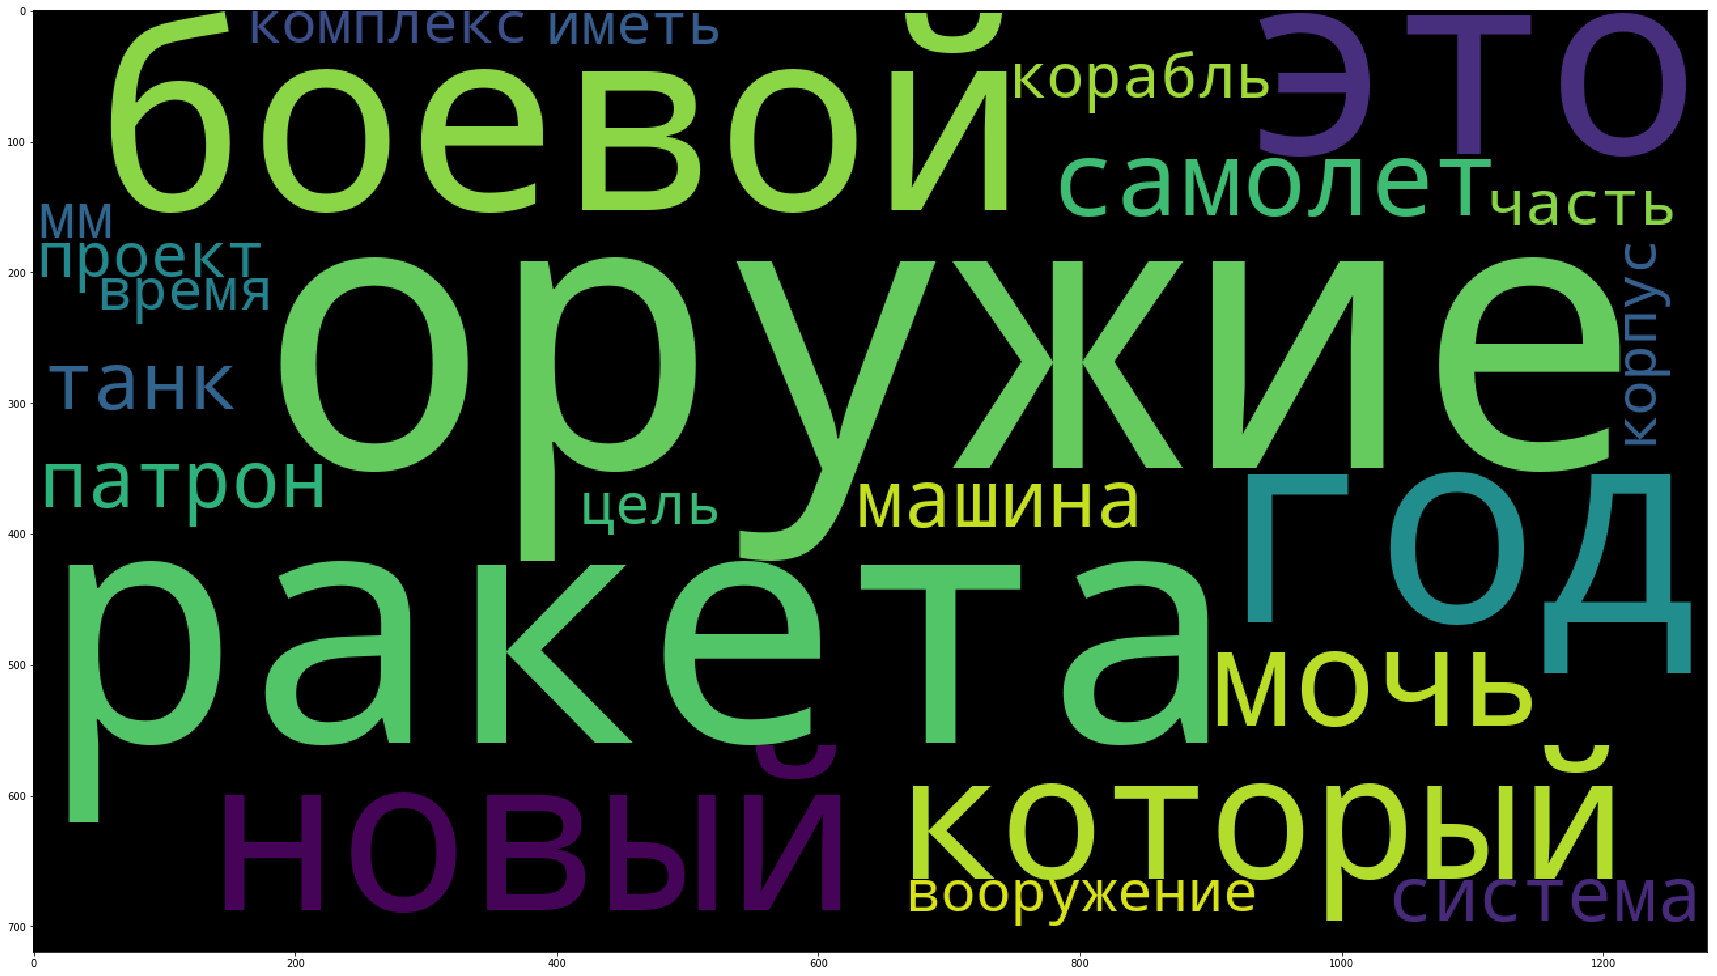

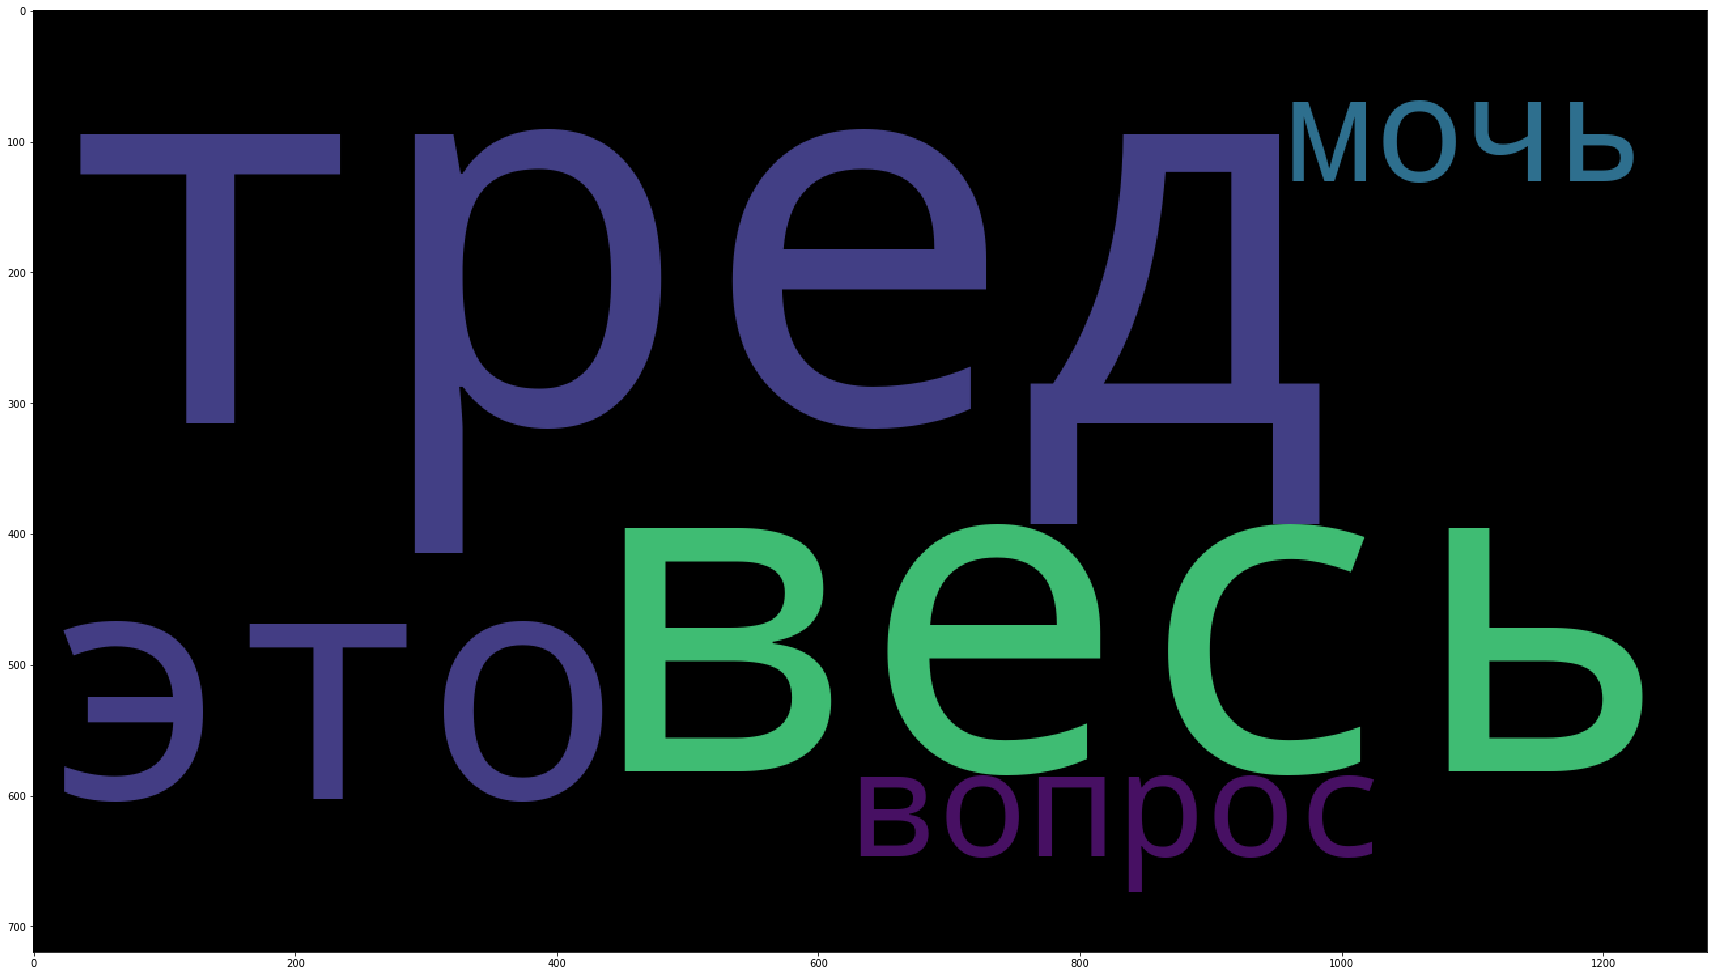

In [23]:
import matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = (30, 24)
for wc in wcs:
    matplotlib.pyplot.imshow(wc)
    matplotlib.pyplot.show()